#### Deep Q-Learning (DQN)

In [1]:
import gymnasium as gym
import numpy as np
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import time

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Neural Network for Q-Learning
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (np.array(states), np.array(actions), np.array(rewards),
                np.array(next_states), np.array(dones))

    def size(self):
        return len(self.buffer)
    
# DQN Agent
class DQNAgent:
    def __init__(self, state_size, action_size, gamma=0.99, lr=1e-3,
                 buffer_size=10000, batch_size=64, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.lr = lr
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size

        # Initialize networks and move them to GPU
        self.q_network = QNetwork(state_size, action_size).to(device)
        self.target_network = QNetwork(state_size, action_size).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.memory = ReplayBuffer(buffer_size)

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.action_size - 1)
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = self.q_network(state_tensor)
        return torch.argmax(q_values).item()

    def train(self):
        if self.memory.size() < self.batch_size:
            return
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        # Convert to PyTorch tensors and move to GPU
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).to(device)

        # Compute Q targets
        with torch.no_grad():
            max_next_q = self.target_network(next_states).max(1)[0]
            q_targets = rewards + (1 - dones) * self.gamma * max_next_q

        # Compute current Q values
        current_q = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze()

        # Loss and optimization
        loss = nn.MSELoss()(current_q, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())


In [4]:
# Main Training Loop
env = gym.make("CartPole-v1")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

agent = DQNAgent(state_size, action_size)
episodes = 500
target_update_freq = 10
rewards_per_episode = []

for episode in tqdm(range(episodes)):
    state, _ = env.reset()
    total_reward = 0
    done = False

    while not done:
        action = agent.select_action(state)
        next_state, reward, done, _, _ = env.step(action)

        agent.memory.add(state, action, reward, next_state, done)
        agent.train()
        state = next_state
        total_reward += reward

    rewards_per_episode.append(total_reward)
    agent.epsilon = max(agent.epsilon * agent.epsilon_decay, agent.epsilon_min)

    if episode % target_update_freq == 0:
        agent.update_target_network()
  
    # print(f"Episode {episode+1}/{episodes}, Reward: {total_reward}, Epsilon: {agent.epsilon:.3f}")

100%|██████████| 500/500 [05:05<00:00,  1.64it/s]


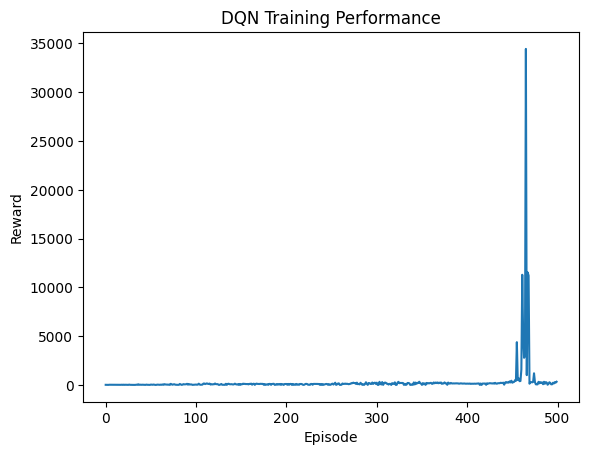

In [5]:
# Plot Rewards
import matplotlib.pyplot as plt
plt.plot(rewards_per_episode)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("DQN Training Performance")
plt.show()

In [6]:
done = False
env = gym.make("CartPole-v1", render_mode="human")  # Enable rendering
state, _ = env.reset()
start_time = time.time()
while not done:
    action = agent.select_action(state)
    state, _, done, _, _ = env.step(action)
print(time.time() - start_time)
input()
env.close()

5.860745429992676
